# Module 7

## Video 33: Analysing Imports/Exports Data
**Python for the Energy Industry**

We will now extend the work of the previous lesson towards and example of analysing data on imports and exports.


[Cargo Time Series documentation.](https://vortechsa.github.io/python-sdk/endpoints/cargo_timeseries/)


In [1]:
# initial imports
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
import vortexasdk as v

# The cargo unit for the time series (barrels)
TS_UNIT = 'b'

# The granularity of the time series
TS_FREQ = 'day'
# datetimes to access last 7 weeks of data
now = datetime.utcnow()
seven_weeks_ago = now - relativedelta(weeks=7)

/var/folders/js/1d4sm_gs33n2lr86b3p7pyvm0000gn/T/ipykernel_43725/236131927.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Let's grab the Chinese imports data, as we did in the previous lesson:

In [2]:
# Find China ID
china = [g.id for g in v.Geographies().search('china').to_list() if 'country' in g.layer]
assert len(china) == 1

search_result = v.CargoTimeSeries().search(
    timeseries_frequency=TS_FREQ,
    timeseries_unit=TS_UNIT,
    filter_destinations=china,
    filter_time_min=seven_weeks_ago,
    filter_time_max=now,
    filter_activity="unloading_state",
)

imports_df = search_result.to_df().rename(columns={'key':'date','value':'total'})[['date','total']]

In [3]:
imports_df.head()

,date,total
0,2024-03-01 00:00:00+00:00,39477958
1,2024-03-02 00:00:00+00:00,60238095
2,2024-03-03 00:00:00+00:00,58922606
3,2024-03-04 00:00:00+00:00,58042811
4,2024-03-05 00:00:00+00:00,53840072


Now we'll break this data up by the exporting shipping region. First, we get the names and IDs of each shipping region:

In [4]:
shipping_regions = [g for g in v.Geographies().search() if 'shipping_region' in g['layer']]

shipping_region_names = [sr['name'] for sr in shipping_regions]
shipping_region_IDs = [sr['id'] for sr in shipping_regions]

# zip into a dictionary
shipping_region_dict = dict(zip(shipping_region_names,shipping_region_IDs))
print(len(shipping_region_dict))

36


We can now loop over each shipping region, and add the time series data for exported by that region on to our DataFrame.

In [5]:
for shipping_region in shipping_region_dict:
    search_result = v.CargoTimeSeries().search(
        timeseries_frequency=TS_FREQ,
        timeseries_unit=TS_UNIT,
        filter_destinations=china,
        filter_origins=shipping_region_dict[shipping_region],
        filter_time_min=seven_weeks_ago,
        filter_time_max=now,
        filter_activity="unloading_state",
    )

    df_sr = search_result.to_df()
    imports_df[shipping_region] = df_sr['value']

Let's take a peek at the top exporting regions among Chinese imports:

In [7]:
imports_df.sum(numeric_only=True).sort_values(ascending=False).head(10)

total                             2814003471
Persian Gulf                      1101131077
East Asia                          526131636
Russia Far East                    202566183
West Africa                        145545825
US Gulf Coast / Gulf of Mexico     139310077
South East Asia                    117397695
South America East Coast           113521997
East Australia and New Zealand      70636320
West Australia                      55952838
dtype: int64

Text(0, 0.5, 'Imports to China (barrels)')

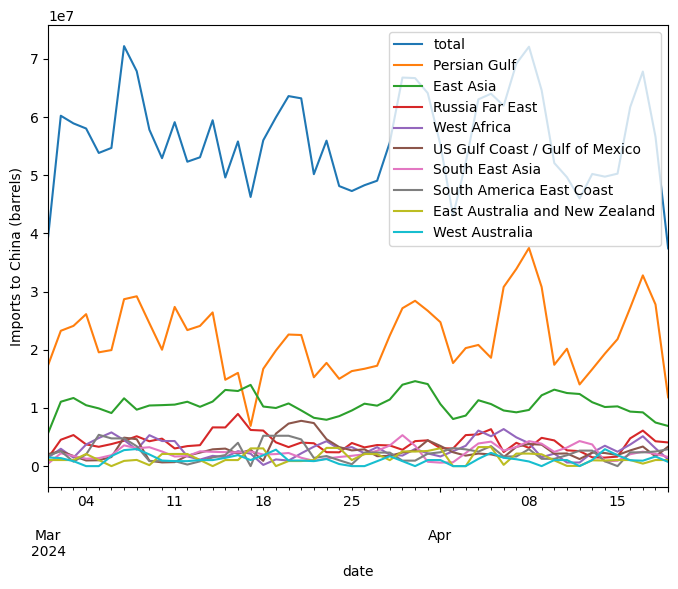

In [8]:
top10 = imports_df.sum(numeric_only=True).sort_values(ascending=False).head(10)

ax = imports_df.plot(x='date',y=top10.index.values,figsize=(8,6))
ax.set_ylabel('Imports to China (barrels)')

### Exercise

Try applying this analysis to US imports.